# Machine Learning Models - Automation

A one‐stop script: suggests techniques, preprocesses data, and runs classification, clustering, regression, anomaly detection, time series forecasting, recommender, NLP, and basic deep learning.

In [2]:
# import libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler,
    OneHotEncoder, OrdinalEncoder
)
# Classification & deep learning imports & metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_auc_score,
    mean_squared_error, r2_score,
    silhouette_samples,   
    confusion_matrix, 
    ConfusionMatrixDisplay,
    roc_curve, RocCurveDisplay
)

# Clustering imports & metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Regression imports
from sklearn.ensemble import RandomForestRegressor

# Anomaly detection
from sklearn.ensemble import IsolationForest

# Time Series Forecasting (ARIMA)
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Recommender System (User-Item CF via Nearest Neighbors)
from sklearn.neighbors import NearestNeighbors

# NLP Workflow (TF-IDF + Supervised or Unsupervised)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression

# for visulizations
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD, PCA

In [4]:
# ┌─────────────────────────────────────────────────────────────┐
# │ Model Suggestion + Model Function Definitions                     │
# └─────────────────────────────────────────────────────────────┘

# Suggestion engine
def suggest_techniques(df):
    suggestions = []
    # 1a. Supervised targets
    for col in df.columns:
        nunique = df[col].nunique()
        dtype = df[col].dtype

        if nunique == 2 and dtype in ["int64", "object", "bool", "category"]:
            suggestions.append({
                "mode": "classification",
                "algo": "logistic_regression / decision_tree / mlp",
                "target": col,
                "business": f"Binary column '{col}' → churn/fraud predictor or deep learning classifier."
            })
        elif 2 < nunique <= 10 and dtype in ["int64", "object", "category"]:
            suggestions.append({
                "mode": "classification",
                "algo": "random_forest / xgboost / mlp",
                "target": col,
                "business": f"Multiclass '{col}' ({nunique} classes) → product choice or segment prediction."
            })
        elif dtype in ["float64", "int64"] and nunique > 10:
            suggestions.append({
                "mode": "regression",
                "algo": "linear_regression / random_forest / mlp",
                "target": col,
                "business": f"Continuous '{col}' → forecast spend, CLV, sales."
            })

    # 1b. Time series?
    datetime_cols = df.select_dtypes(include=["datetime64", "object"]).columns.tolist()
    for col in datetime_cols:
        try:
            pd.to_datetime(df[col])
            suggestions.append({
                "mode": "timeseries",
                "algo": "ARIMA",
                "target": None,
                "time_col": col,
                "business": f"Datetime '{col}' found → time series forecasting."
            })
            break
        except:
            continue

    # 1c. NLP?
    text_cols = df.select_dtypes(include=["object"]).nunique()
    for col, uniq in text_cols.items():
        if uniq > 20 and df[col].astype(str).map(len).mean()>20:
            suggestions.append({
                "mode": "nlp",
                "algo": "tfidf + (logistic_regression / kmeans)",
                "target": None,
                "text_col": col,
                "business": f"Free-text '{col}' → sentiment/topic modeling or text classification."
            })
            break

    # 1d. Recommender?
    if set(["user_id","item_id"]).issubset(df.columns):
        suggestions.append({
            "mode": "recommender",
            "algo": "NearestNeighbors",
            "target": None,
            "business": "User-item data → collaborative filtering recommendations."
        })

    # 1e. Anomaly detection
    suggestions.append({
        "mode": "anomaly",
        "algo": "IsolationForest",
        "target": None,
        "business": "Detect outliers/fraud in your numeric features."
    })

    # 1f. Clustering fallback
    if not any(s["mode"] in ["classification","regression","timeseries","nlp","recommender"] for s in suggestions):
        suggestions.append({
            "mode": "clustering",
            "algo": "kmeans / hierarchical",
            "target": None,
            "business": "No clear target → discover customer segments."
        })

    return suggestions

def print_suggestions(df):
    print("\n=== Modeling Suggestions ===\n")
    for s in suggest_techniques(df):
        tgt = f", target='{s['target']}'" if s.get("target") else ""
        tm = f", time_col='{s['time_col']}'" if s.get("time_col") else ""
        txt = f", text_col='{s['text_col']}'" if s.get("text_col") else ""
        print(f"- [{s['mode']}]{tgt}{tm}{txt}: {s['algo']}")
        print(f"  → {s['business']}\n")
    print("Choose mode, algorithm, and any needed columns below.\n")

# -----------------------------
# 2. Universal Preprocessor
# -----------------------------
def preprocess_data(X, algorithm_name, model_family):
    df = X.copy()
    
    # 1. Detect feature types
    num_cols = df.select_dtypes(include="number").columns.tolist()
    cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

    # 2. Impute missing values (avoid inplace on slices)
    #    Numeric: median; Categorical: "missing"
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())
    df[cat_cols] = df[cat_cols].fillna("missing")

    # 3. Pick scaler
    scaler = StandardScaler() if algorithm_name in (
        "svm","knn","logistic_regression","linear_regression",
        "kmeans","pca","tsne","umap"
    ) else None

    # 4. Pick encoder (use sparse_output in newer sklearn)
    if algorithm_name in (
        "svm","knn","logistic_regression","linear_regression",
        "pca","tsne","umap"
    ):
        encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    elif model_family == "classification":
        encoder = OrdinalEncoder()
    else:
        encoder = None

    # 5. Build ColumnTransformer
    transformers = []
    if scaler and num_cols:
        transformers.append(("scale", scaler, num_cols))
    if encoder and cat_cols:
        transformers.append(("encode", encoder, cat_cols))

    from sklearn.compose import ColumnTransformer
    preproc = ColumnTransformer(transformers, remainder="passthrough")

    # 6. Fit & transform
    X_prepared = preproc.fit_transform(df)
    return X_prepared, preproc

# -----------------------------
# 3a. Classification Workflow
# -----------------------------
def run_classification(df, target, algo):
    X, y = df.drop(target, axis=1), df[target]
    X_pre, _ = preprocess_data(X, algo, "classification")
    X_train, X_test, y_train, y_test = train_test_split(
        X_pre, y, test_size=0.2, random_state=42
    )

    if algo == "decision_tree":
        model = DecisionTreeClassifier(max_depth=5, random_state=42)
    elif algo == "logistic_regression":
        model = LogisticRegression(max_iter=1_000)
    elif algo == "mlp":
        model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
    else:
        raise ValueError(f"Unknown classification algo '{algo}'")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    print("\n--- Classification Metrics ---")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    if y_proba is not None:
        print("ROC AUC  :", roc_auc_score(y_test, y_proba))

    cv = cross_val_score(model, X_pre, y, cv=5, scoring="accuracy")
    print("CV Accuracy:", np.mean(cv))

    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    # 2. ROC Curve (if probabilities exist)
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
        plt.title("ROC Curve")
        plt.show()
    
# -----------------------------
# 3b. Clustering Workflow
# -----------------------------
def run_clustering(df, algo):
    X_pre, _ = preprocess_data(df, algo, "clustering")
    if algo != "kmeans":
        raise ValueError(f"Only 'kmeans' supported, got '{algo}'")
    model = KMeans(n_clusters=3, random_state=42)
    labels = model.fit_predict(X_pre)

    print("\n--- Clustering Metrics ---")
    print("Silhouette Score     :", silhouette_score(X_pre, labels))
    print("Davies–Bouldin Index :", davies_bouldin_score(X_pre, labels))

    # 1. 2-D PCA projection
    coords = PCA(n_components=2).fit_transform(X_pre)
    plt.figure(figsize=(6,5))
    plt.scatter(coords[:,0], coords[:,1], c=labels, cmap="tab10", alpha=0.7)
    plt.title("PCA of Clusters")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.show()

    # 2. Silhouette‐score histogram
    sil_scores = silhouette_samples(X_pre, labels)
    sns.histplot(sil_scores, bins=20, kde=True)
    plt.title("Silhouette Scores")
    plt.xlabel("Score")
    plt.show()

# -----------------------------
# 3c. Regression Workflow
# -----------------------------
def run_regression(df, target, algo):
    X, y = df.drop(target, axis=1), df[target]
    X_pre, _ = preprocess_data(X, algo, "regression")
    X_train, X_test, y_train, y_test = train_test_split(
        X_pre, y, test_size=0.2, random_state=42
    )

    if algo.lower() == "random_forest":
        model = RandomForestRegressor(n_estimators=100, random_state=42)

    elif algo.lower() == "linear_regression":
        model = LinearRegression()

    else:
        raise ValueError(f"Only 'random_forest' or 'linear_regression' supported, got '{algo}'")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("\n--- Regression Metrics ---")
    print(f"MSE  : {mean_squared_error(y_test, y_pred):.4f}")
    print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
    print(f"R2   : {r2_score(y_test, y_pred):.4f}")

    # 1. Actual vs Predicted
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    mn, mx = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
    plt.plot([mn, mx], [mn, mx], "r--")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs. Predicted")
    plt.show()

    # 2. Residual Distribution
    residuals = y_test - y_pred
    sns.histplot(residuals, kde=True)
    plt.title("Residuals Distribution")
    plt.show()

# 3d. Anomaly Detection
# -----------------------------
def run_anomaly(df, algo):
    X_pre, _ = preprocess_data(df, algo, "anomaly")
    if algo != "isolation_forest":
        raise ValueError(f"Only 'isolation_forest' supported, got '{algo}'")

    # Fit the Isolation Forest model
    model = IsolationForest(contamination=0.05, random_state=42)
    preds = model.fit_predict(X_pre)          # -1 for anomaly, 1 for normal
    scores = model.decision_function(X_pre)   # anomaly score (lower → more anomalous)
    n_anom = (preds == -1).sum()

    # Print results
    print("\n--- Anomaly Detection ---")
    print(f"Total records       : {len(df)}")
    print(f"Anomalies detected  : {n_anom} ({n_anom/len(df):.2%})")

    # Show the lowest anomaly scores (5 most outlying points)
    lowest_idx = np.argsort(scores)[:5]
    print("\nTop 5 anomaly scores (lowest):")
    for idx in lowest_idx:
        print(f"  Index {idx} → score = {scores[idx]:.4f}")

    # Optionally return the labels and scores for downstream use
    return preds, scores

    # 1. Anomaly‐score distribution
    sns.histplot(scores, bins=30, kde=True)
    plt.title("Anomaly Score Distribution")
    plt.show()

    # 2. PCA scatter colored by anomaly flag
    coords = PCA(n_components=2).fit_transform(X_pre)
    plt.figure(figsize=(6,5))
    plt.scatter(coords[:,0], coords[:,1], c=preds, cmap="coolwarm", alpha=0.7)
    plt.title("IsolationForest: Normal vs Anomaly")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.show()

def run_timeseries(df, time_col, target, algo):
    if algo.lower() != "arima":
        raise ValueError(f"Only 'arima' supported, got '{algo}'")

    # prepare series
    ts_df = df.copy()
    ts_df[time_col] = pd.to_datetime(ts_df[time_col])
    ts_df = ts_df.set_index(time_col)
    series = ts_df[target].dropna().astype(float)

    # train/test split (80/20)
    split = int(len(series) * 0.8)
    train, test = series[:split], series[split:]

    # fit ARIMA
    model = ARIMA(train, order=(1, 1, 1))
    res = model.fit()
    forecast = res.forecast(steps=len(test))

    # metrics
    mse = mean_squared_error(test, forecast)
    rmse = np.sqrt(mse)

    print("\n--- Time Series Forecasting (ARIMA) ---")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")

    plt.figure(figsize=(8,4))
    train.plot(label="Train")
    test.plot(label="Test")
    forecast.plot(label="Forecast")
    plt.legend()
    plt.title("ARIMA Forecast vs Actual")
    plt.show()


def run_recommender(df, algo):
    if algo.lower() != "nearest_neighbors":
        raise ValueError(f"Only 'nearest_neighbors' supported, got '{algo}'")

    # prompt for columns
    user_col   = input("User ID column: ").strip()
    item_col   = input("Item ID column: ").strip()
    rating_col = input("Rating/interaction column: ").strip()

    # pivot to user-item matrix
    mat = (
        df[[user_col, item_col, rating_col]]
        .pivot(index=user_col, columns=item_col, values=rating_col)
        .fillna(0)
    )

    # fit model
    model = NearestNeighbors(metric="cosine", algorithm="brute")
    model.fit(mat)

    # sample recommendations for first user
    user0 = mat.index[0:1]
    dists, idxs = model.kneighbors(mat.loc[user0], n_neighbors=6)
    rec_items = mat.columns[idxs.flatten()[1:6]]

    print("\n--- Recommender Sample ---")
    print(f"Top recommendations for user '{user0[0]}': {list(rec_items)}")


def run_nlp(df, algo):
    text_col = input("Free-text column: ").strip()
    texts = df[text_col].fillna("").astype(str)
    tfidf = TfidfVectorizer(max_features=5000)
    X_tfidf = tfidf.fit_transform(texts)

    # Supervised text classification
    if algo.lower() in ["nlp_classification", "text_classification"]:
        target = input("Target column: ").strip()
        y = df[target]
        X_train, X_test, y_train, y_test = train_test_split(
            X_tfidf, y, test_size=0.2, random_state=42
        )
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        print("\n--- NLP Classification ---")
        print("Accuracy :", accuracy_score(y_test, preds))
        print("Precision:", precision_score(y_test, preds))
        print("Recall   :", recall_score(y_test, preds))

    # Unsupervised text clustering
    elif algo.lower() in ["nlp_clustering", "text_clustering"]:
        n_clusters = int(input("Number of clusters: ").strip() or 5)
        model = KMeans(n_clusters=n_clusters, random_state=42)
        labels = model.fit_predict(X_tfidf)

        print("\n--- NLP Unsupervised (KMeans) ---")
        print("Silhouette Score:", silhouette_score(X_tfidf, labels))

    else:
        raise ValueError(f"Unknown NLP algo '{algo}'")


# Unified entry point
def run_ml_pipeline(
    file_path: str,
    mode: str,
    algo: str,
    target: str = None,
    time_col: str = None,
    user_col: str = None,
    item_col: str = None,
    rating_col: str = None,
    text_col: str = None,
    n_clusters: int = None
):
    df = pd.read_csv(file_path)
    print_suggestions(df)

    if mode == "classification":
        run_classification(df, target, algo)
    elif mode == "clustering":
        run_clustering(df, algo)
    elif mode == "regression":
        run_regression(df, target, algo)
    elif mode == "anomaly":
        run_anomaly(df, algo)
    elif mode == "timeseries":
        run_timeseries(df, time_col, target, algo)
    elif mode == "recommender":
        run_recommender(df, algo)
    elif mode == "nlp":
        run_nlp(df, algo)
    else:
        raise ValueError(f"Unknown mode {mode}")

### Load your dataset

In [6]:
# Cell 2: load data & suggestions

# add path to your input file:
DATA_PATH = "/Users/ariba/OneDrive/Datasets/coffee_shop_revenue.csv"    
df = pd.read_csv(DATA_PATH)
print_suggestions(df)


=== Modeling Suggestions ===

- [regression], target='Number_of_Customers_Per_Day': linear_regression / random_forest / mlp
  → Continuous 'Number_of_Customers_Per_Day' → forecast spend, CLV, sales.

- [regression], target='Average_Order_Value': linear_regression / random_forest / mlp
  → Continuous 'Average_Order_Value' → forecast spend, CLV, sales.

- [regression], target='Operating_Hours_Per_Day': linear_regression / random_forest / mlp
  → Continuous 'Operating_Hours_Per_Day' → forecast spend, CLV, sales.

- [regression], target='Number_of_Employees': linear_regression / random_forest / mlp
  → Continuous 'Number_of_Employees' → forecast spend, CLV, sales.

- [regression], target='Marketing_Spend_Per_Day': linear_regression / random_forest / mlp
  → Continuous 'Marketing_Spend_Per_Day' → forecast spend, CLV, sales.

- [regression], target='Location_Foot_Traffic': linear_regression / random_forest / mlp
  → Continuous 'Location_Foot_Traffic' → forecast spend, CLV, sales.

- [regres

In [8]:
df.head()

,Number_of_Customers_Per_Day,Average_Order_Value,Operating_Hours_Per_Day,Number_of_Employees,Marketing_Spend_Per_Day,Location_Foot_Traffic,Daily_Revenue
0,152,6.74,14,4,106.62,97,1547.81
1,485,4.50,12,8,57.83,744,2084.68
2,398,9.09,6,6,91.76,636,3118.39
3,320,8.48,17,4,462.63,770,2912.20
4,156,7.44,17,2,412.52,232,1663.42


### Set your “mode” & parameters as input parameters

| Parameter   | Description                                   | Required For Modes                        |
|-------------|-----------------------------------------------|-------------------------------------------|
| file_path   | Path to your CSV file                         | All                                       |
| mode        | One of: classification, clustering, regression, anomaly, timeseries, recommender, nlp | All          |
| algo        | Algorithm key (e.g. decision_tree, logistic_regression, random_forest, kmeans, isolation_forest, arima, nearest_neighbors, mlp, nlp_classification, nlp_clustering) | All |
| target      | Name of target (label) column                 | classification, regression, timeseries    |
| time_col    | Name of timestamp column                      | timeseries                                |
| user_col    | User ID column                                | recommender                               |
| item_col    | Item ID column                                | recommender                               |
| rating_col  | Rating or interaction column                  | recommender                               |
| text_col    | Free‐text column                              | nlp                                       |
| n_clusters  | Number of clusters for clustering/NLP         | clustering, nlp_clustering                |


=== Modeling Suggestions ===

- [regression], target='Number_of_Customers_Per_Day': linear_regression / random_forest / mlp
  → Continuous 'Number_of_Customers_Per_Day' → forecast spend, CLV, sales.

- [regression], target='Average_Order_Value': linear_regression / random_forest / mlp
  → Continuous 'Average_Order_Value' → forecast spend, CLV, sales.

- [regression], target='Operating_Hours_Per_Day': linear_regression / random_forest / mlp
  → Continuous 'Operating_Hours_Per_Day' → forecast spend, CLV, sales.

- [regression], target='Number_of_Employees': linear_regression / random_forest / mlp
  → Continuous 'Number_of_Employees' → forecast spend, CLV, sales.

- [regression], target='Marketing_Spend_Per_Day': linear_regression / random_forest / mlp
  → Continuous 'Marketing_Spend_Per_Day' → forecast spend, CLV, sales.

- [regression], target='Location_Foot_Traffic': linear_regression / random_forest / mlp
  → Continuous 'Location_Foot_Traffic' → forecast spend, CLV, sales.

- [regres

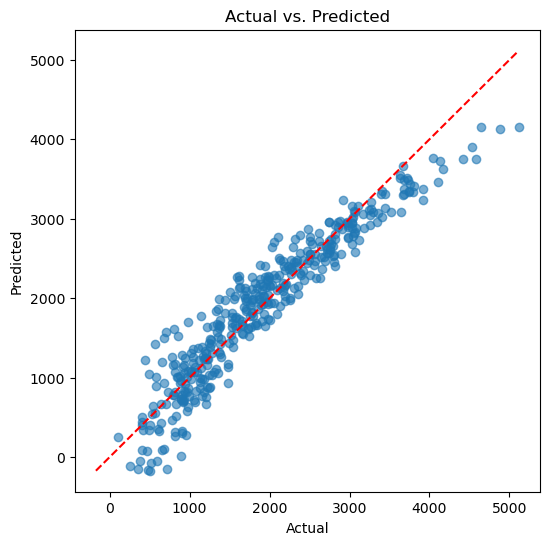

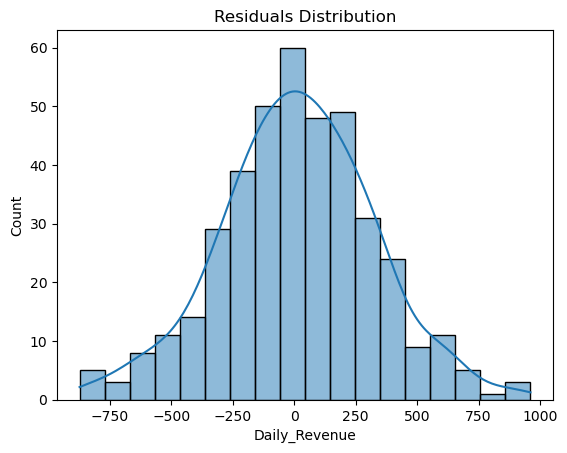

In [10]:
# Running linear regression to predict daily revenue of coffee
run_ml_pipeline(
    file_path=DATA_PATH,
    mode="regression",
    algo="linear_regression",
    target="Daily_Revenue"
)

In [12]:
# running anomaly detection
run_ml_pipeline(
    file_path=DATA_PATH,
    mode="anomaly",
    algo="isolation_forest"
)


=== Modeling Suggestions ===

- [regression], target='Number_of_Customers_Per_Day': linear_regression / random_forest / mlp
  → Continuous 'Number_of_Customers_Per_Day' → forecast spend, CLV, sales.

- [regression], target='Average_Order_Value': linear_regression / random_forest / mlp
  → Continuous 'Average_Order_Value' → forecast spend, CLV, sales.

- [regression], target='Operating_Hours_Per_Day': linear_regression / random_forest / mlp
  → Continuous 'Operating_Hours_Per_Day' → forecast spend, CLV, sales.

- [regression], target='Number_of_Employees': linear_regression / random_forest / mlp
  → Continuous 'Number_of_Employees' → forecast spend, CLV, sales.

- [regression], target='Marketing_Spend_Per_Day': linear_regression / random_forest / mlp
  → Continuous 'Marketing_Spend_Per_Day' → forecast spend, CLV, sales.

- [regression], target='Location_Foot_Traffic': linear_regression / random_forest / mlp
  → Continuous 'Location_Foot_Traffic' → forecast spend, CLV, sales.

- [regres


=== Modeling Suggestions ===

- [regression], target='Number_of_Customers_Per_Day': linear_regression / random_forest / mlp
  → Continuous 'Number_of_Customers_Per_Day' → forecast spend, CLV, sales.

- [regression], target='Average_Order_Value': linear_regression / random_forest / mlp
  → Continuous 'Average_Order_Value' → forecast spend, CLV, sales.

- [regression], target='Operating_Hours_Per_Day': linear_regression / random_forest / mlp
  → Continuous 'Operating_Hours_Per_Day' → forecast spend, CLV, sales.

- [regression], target='Number_of_Employees': linear_regression / random_forest / mlp
  → Continuous 'Number_of_Employees' → forecast spend, CLV, sales.

- [regression], target='Marketing_Spend_Per_Day': linear_regression / random_forest / mlp
  → Continuous 'Marketing_Spend_Per_Day' → forecast spend, CLV, sales.

- [regression], target='Location_Foot_Traffic': linear_regression / random_forest / mlp
  → Continuous 'Location_Foot_Traffic' → forecast spend, CLV, sales.

- [regres

C:\Users\ariba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(



--- Clustering Metrics ---
Silhouette Score     : 0.14298550832342852
Davies–Bouldin Index : 2.1215590952287893


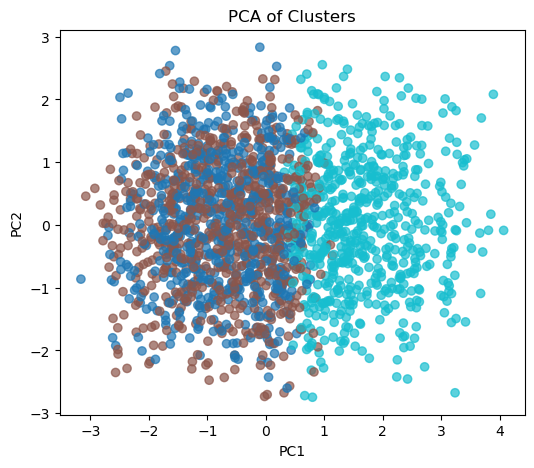

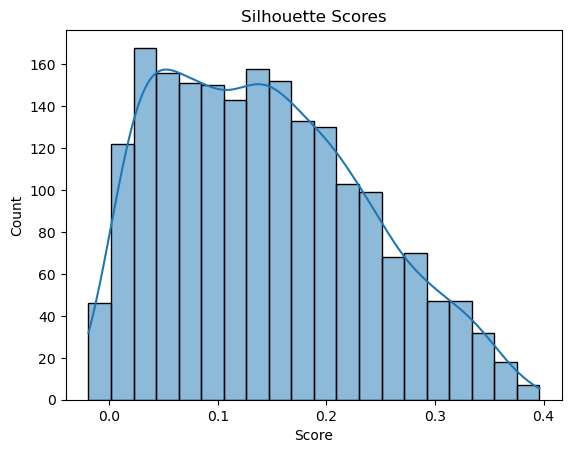

In [14]:
# Cusotomer day segmentation
run_ml_pipeline(
  file_path=DATA_PATH,
  mode="clustering",
  algo="kmeans"
)